<a href="https://colab.research.google.com/github/Teacher-Heiko/course22p2/blob/master/nbs/03_backprop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## The forward and backward passes

In [32]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl, numpy as np
from pathlib import Path
from torch import tensor
from fastcore.test import test_close
torch.manual_seed(42)

mpl.rcParams['image.cmap'] = 'gray'
torch.set_printoptions(precision=2, linewidth=125, sci_mode=False)
np.set_printoptions(precision=2, linewidth=125)


In [33]:
# from google.colab import drive
# drive.mount('/content/drive')
# path_data = Path('/content/drive/My Drive')
# list(path_data.iterdir())

In [34]:

path_data = Path('../')
path_gz = path_data/'mnist.pkl.gz'
with gzip.open(path_gz, 'rb') as f: ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
x_train, y_train, x_valid, y_valid = map(tensor, [x_train, y_train, x_valid, y_valid])

## Foundations version

### Basic architecture

In [35]:
n,m = x_train.shape
c = y_train.max()+1
n,m,c

(50000, 784, tensor(10))

In [36]:
# num hidden neurons activations or lines in the graph examplle
nh = 50

In [37]:
w1 = torch.randn(m,nh) # 1st layer
b1 = torch.zeros(nh)
w2 = torch.randn(nh,1) # 2nd layer with one output only for MSE to simplify calculations (MSE is stupid idea)
b2 = torch.zeros(1)

In [38]:
def lin(x, w, b): return x@w + b

#Matmul

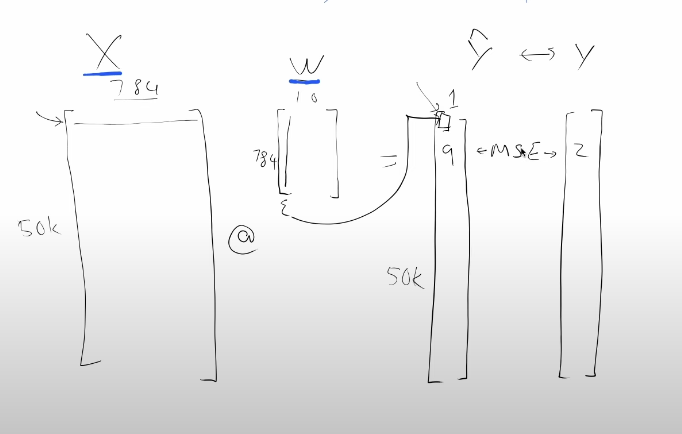![image.png]()

In [39]:
t = lin(x_valid, w1, b1)
t.shape

torch.Size([10000, 50])

In [40]:
def relu(x): return x.clamp_min(0.)

In [41]:
t = relu(t)
t

tensor([[ 0.00, 11.87,  0.00,  ...,  5.48,  2.14, 15.30],
        [ 5.38, 10.21,  0.00,  ...,  0.88,  0.08, 20.23],
        [ 3.31,  0.12,  3.10,  ..., 16.89,  0.00, 24.74],
        ...,
        [ 4.01, 10.35,  0.00,  ...,  0.23,  0.00, 18.28],
        [10.62,  0.00, 10.72,  ...,  0.00,  0.00, 18.23],
        [ 2.84,  0.00,  1.43,  ...,  0.00,  5.75,  2.12]])

In [42]:
def model(xb):
    l1 = lin(xb, w1, b1)
    l2 = relu(l1)
    return lin(l2, w2, b2)

In [43]:
res = model(x_valid)
res.shape

torch.Size([10000, 1])

### Loss function: MSE

(Of course, `mse` is not a suitable loss function for multi-class classification; we'll use a better loss function soon. We'll use `mse` for now to keep things simple.)

In [44]:
res.shape,y_valid.shape

(torch.Size([10000, 1]), torch.Size([10000]))

In [45]:
(res-y_valid).shape

torch.Size([10000, 10000])

We need to get rid of that trailing (,1), in order to use `mse`.

In [46]:
res[:,0].shape

torch.Size([10000])

In [47]:
res.squeeze().shape

torch.Size([10000])

In [48]:
(res[:,0]-y_valid).shape

torch.Size([10000])

In [49]:
y_train,y_valid = y_train.float(),y_valid.float()

preds = model(x_train)
preds.shape

torch.Size([50000, 1])

In [50]:
def mse(output, targ): return (output[:,0]-targ).pow(2).mean()

In [51]:
mse(preds, y_train)

tensor(4308.76)

### Gradients and backward pass

In [52]:
from sympy import symbols,diff
x,y = symbols('x y')
diff(x**2, x)

2*x

In [53]:
diff(3*x**2+9, x)

6*x

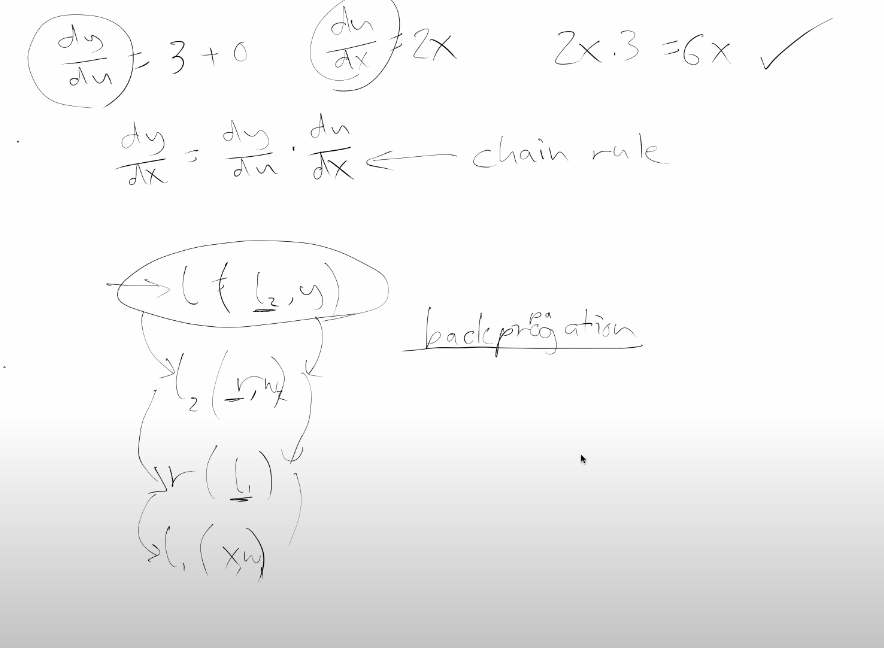

In [54]:
def lin_grad(inp, out, w, b):
    inp.g = out.g @ w.t()
    w.g = (inp.unsqueeze(-1) * out.g.unsqueeze(1)).sum(0)
    # for debugging
    # i,o = inp.unsqueeze(-1), out.g.unsqueeze(1)
    # w.g = (i * o).sum(0)
    b.g = out.g.sum(0)

In [55]:
def lin_grad(inp, out, w, b):
    inp.g = out.g @ w.t()
# The line `inp.g = out.g @ w.t()` calculates the gradient of the input to a linear layer with respect to the loss. This is part of the backpropagation process in a neural network, which is used to update the weights and biases to minimize the loss.
# Here's a step-by-step explanation:
# 1. `out.g`: This is the gradient of the loss with respect to the output of the linear layer. It's calculated during the backward pass of backpropagation.
# 2. `w.t()`: This is the transpose of the weight matrix `w`. Transposing the matrix is necessary because of the way matrix multiplication works.
# 3. `out.g @ w.t()`: The `@` operator represents matrix multiplication in Python. This line performs a matrix multiplication between the gradient of the loss with respect to the output and the transpose of the weight matrix. The result is a matrix that represents the gradient of the loss with respect to the input to the linear layer.
# 4. `inp.g = ...`: The result of the matrix multiplication is stored in `inp.g`. This represents the gradient of the loss with respect to the input to the linear layer.
# This gradient is then used to update the input during the training process, with the goal of minimizing the loss.
    w.g = inp.T @ out.g
# This line of code is calculating the gradient of the weights in a linear layer of a neural network during the backward pass of backpropagation. Here's a step-by-step explanation:
# 1. `inp.T`: This is the transpose of the input matrix `inp`. Transposing the matrix is necessary because of the way matrix multiplication works. In the context of a neural network, `inp` would be the input to the layer, which could be either the original input to the network or the output of a previous layer.
# 2. `out.g`: This is the gradient of the loss with respect to the output of the linear layer. It's calculated during the backward pass of backpropagation. The gradient indicates how much the loss would change if the output of the layer were changed by a small amount.
# 3. `inp.T @ out.g`: The `@` operator represents matrix multiplication in Python. This line performs a matrix multiplication between the transpose of the input and the gradient of the loss with respect to the output. The result is a matrix that represents the gradient of the loss with respect to the weights in the linear layer.
# 4. `w.g = ...`: The result of the matrix multiplication is stored in `w.g`. This represents the gradient of the loss with respect to the weights in the linear layer.
# This gradient is then used to update the weights during the training process, with the goal of minimizing the loss. The weights are typically updated by subtracting the gradient times a small learning rate from the current weights.    
    b.g = out.g.sum(0)
# The line `b.g = out.g.sum(0)` is calculating the gradient of the bias in a linear layer of a neural network during the backward pass of backpropagation.
# Here's a step-by-step explanation:
# 1. `out.g`: This is the gradient of the loss with respect to the output of the linear layer. It's calculated during the backward pass of backpropagation. The gradient indicates how much the loss would change if the output of the layer were changed by a small amount.
# 2. `out.g.sum(0)`: The `sum(0)` function calculates the sum of the elements in the gradient matrix along the first dimension (i.e., for each column). In the context of a neural network, this operation effectively sums up the gradients for each instance in the batch. This is necessary because the bias is a single value added to all instances in the batch, so its gradient is the sum of the gradients for each instance.
# 3. `b.g = ...`: The result of the sum operation is stored in `b.g`. This represents the gradient of the loss with respect to the bias in the linear layer.
# This gradient is then used to update the bias during the training process, with the goal of minimizing the loss. The bias is typically updated by subtracting the gradient times a small learning rate from the current bias.    

The `lin_grad` function in this Python code is used to calculate the gradients of the inputs, weights, and bias of a linear layer during the backward pass of backpropagation in a neural network. 

The function takes four arguments: `inp` (the input to the linear layer), `out` (the output of the linear layer), `w` (the weights of the linear layer), and `b` (the bias of the linear layer). Each of these arguments is expected to be a PyTorch tensor.

The gradients stored in `inp.g`, `w.g`, and `b.g` can then be used to update the inputs, weights, and bias, respectively, during the training process. This is typically done using an optimization algorithm like gradient descent. 

In [56]:
def forward_and_backward(inp, targ):
    # forward pass:
    l1 = lin(inp, w1, b1)
    l2 = relu(l1)
    out = lin(l2, w2, b2)
    diff = out[:,0]-targ
    loss = diff.pow(2).mean()

    # backward pass:
    out.g = 2.*diff[:,None] / inp.shape[0]
    lin_grad(l2, out, w2, b2)
    l1.g = (l1>0).float() * l2.g
    lin_grad(inp, l1, w1, b1)

This Python function, `forward_and_backward(inp, targ)`, is part of a simple neural network implementation. It performs both the forward and backward passes of the network.

Here's a step-by-step explanation:

1. **Forward pass:**
   - `l1 = lin(inp, w1, b1)`: This line calculates the linear transformation of the input `inp` using weights `w1` and bias `b1`.
   - `l2 = relu(l1)`: The output `l1` is passed through the ReLU (Rectified Linear Unit) activation function.
   - `out = lin(l2, w2, b2)`: The output `l2` is then passed through another linear transformation using weights `w2` and bias `b2`.
   - `diff = out[:,0]-targ`: The difference between the output of the network and the target values `targ` is calculated.
   - `loss = diff.pow(2).mean()`: The mean squared error loss is calculated from the difference.

2. **Backward pass:**
   - `out.g = 2.*diff[:,None] / inp.shape[0]`: The gradient of the loss with respect to the output is calculated. This is the derivative of the mean squared error loss function.
The line of code `out.g = 2.*diff[:,None] / inp.shape[0]` is part of the backward pass in a neural network, specifically in the calculation of the gradient of the loss function.

Here's a breakdown of what's happening:

1. `diff[:,None]`: This is indexing into the `diff` tensor, which represents the difference between the predicted and actual values (i.e., the error). The `[:,None]` part is used to add an extra dimension to the tensor. This is done to match the shape of the output tensor `out` for subsequent operations.

2. `2.*diff[:,None]`: The `diff` tensor is multiplied by 2. This is because the derivative of the mean squared error loss function with respect to its input is `2*(predicted - actual)`. So, this line is calculating the gradient of the loss with respect to the output of the network.

3. `/ inp.shape[0]`: The result is then divided by the number of instances in the input batch (`inp.shape[0]`). So, `/ inp.shape[0]` means "divide by the batch size". 
This is done because the mean squared error loss function is an average of the squared errors over all instances in the batch. So, when calculating the gradient, we need to take the average into account.

4. `out.g = ...`: The result of these operations is stored in `out.g`. This represents the gradient of the loss with respect to the output of the network. This gradient will be used in subsequent steps of the backward pass to calculate the gradients of the loss with respect to the weights and biases, which are then used to update the weights and biases during the training process.
   - `lin_grad(l2, out, w2, b2)`: The gradients of the weights `w2` and bias `b2` are calculated using the chain rule.
   - `l1.g = (l1>0).float() * l2.g`: The gradient of the ReLU function is calculated. The derivative of ReLU is 1 for input > 0 and 0 otherwise.
   - `lin_grad(inp, l1, w1, b1)`: Finally, the gradients of the weights `w1` and bias `b1` are calculated.

The function does not return anything. It modifies the weights and biases in place, using their gradients. This is a common practice in deep learning libraries to save memory.

A more readable form (source Copilot):
```python 
def relu_backward(grad_y, x):
    grad_input = grad_y.clone()
    grad_input[x < 0] = 0
    return grad_input

def linear_backward(grad_y, x, w, b):
    grad_input = grad_y @ w.t()
    grad_w = x.t() @ grad_y
    grad_b = grad_y.sum(0)
    return grad_input, grad_w, grad_b

# Forward pass (same as before)
h = relu(x @ w1 + b1)
y_pred = h @ w2 + b2

# Compute the loss (same as before)
loss = mse(y_pred, y_true)

# Backward pass
grad_y_pred = 2.0 * (y_pred - y_true)
grad_h, grad_w2, grad_b2 = linear_backward(grad_y_pred, h, w2, b2)
grad_h = relu_backward(grad_h, h)
grad_x, grad_w1, grad_b1 = linear_backward(grad_h, x, w1, b1)
```


In [57]:
forward_and_backward(x_train, y_train)

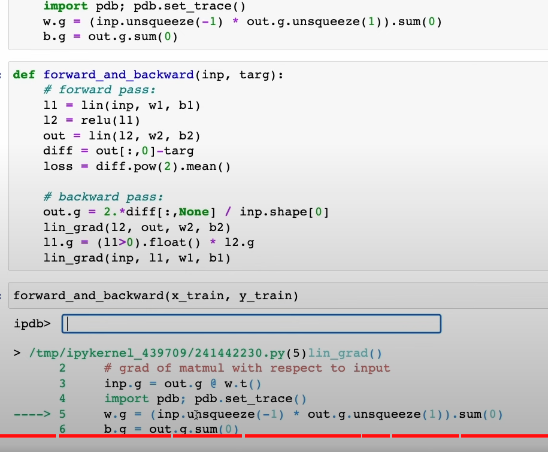

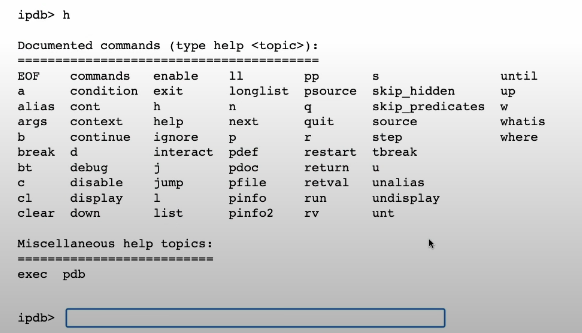

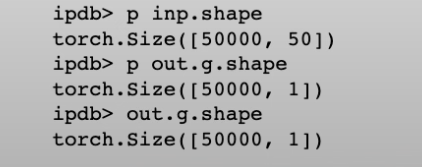

2nd call of lin_grad() - > First layer going into second layer
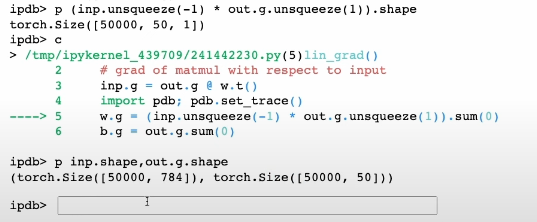

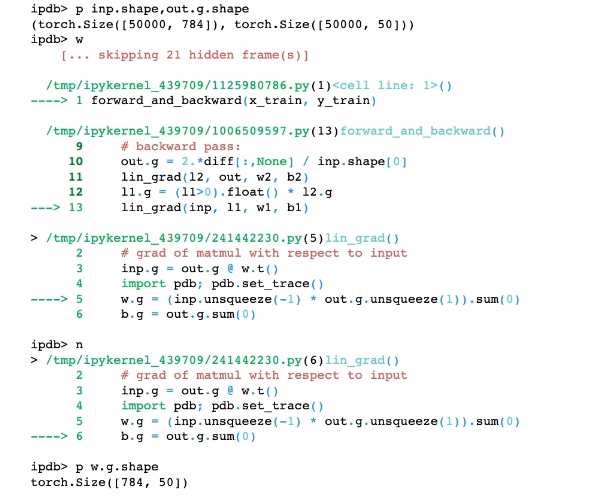

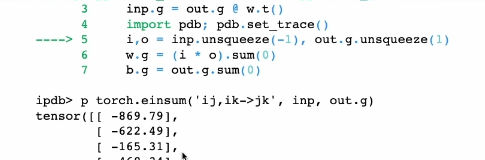

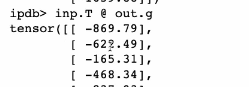

In [58]:
# Save for testing against later
def get_grad(x): return x.g.clone()
chks = w1,w2,b1,b2,x_train
grads = w1g,w2g,b1g,b2g,ig = tuple(map(get_grad, chks))

We cheat a little bit and use PyTorch autograd to check our results.

In [59]:
def mkgrad(x): return x.clone().requires_grad_(True)
ptgrads = w12,w22,b12,b22,xt2 = tuple(map(mkgrad, chks))

In [60]:
def forward(inp, targ):
    l1 = lin(inp, w12, b12)
    l2 = relu(l1)
    out = lin(l2, w22, b22)
    return mse(out, targ)

In [61]:
loss = forward(xt2, y_train)
loss.backward()

In [62]:
for a,b in zip(grads, ptgrads): test_close(a, b.grad, eps=0.01)

## Refactor model

### Layers as classes

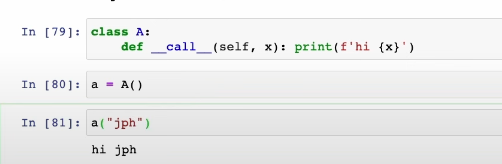

#Note all classes internally store inputs and outputs to reuse them for backward/backpropagation calcuation

In [63]:
class Relu():
    def __call__(self, inp):
        self.inp = inp
        self.out = inp.clamp_min(0.)
        return self.out

    def backward(self): self.inp.g = (self.inp>0).float() * self.out.g

In [64]:
class Lin():
    def __init__(self, w, b): self.w,self.b = w,b

    def __call__(self, inp):
        self.inp = inp
        self.out = lin(inp, self.w, self.b)
        return self.out

    def backward(self):
        self.inp.g = self.out.g @ self.w.t()  # same as w.T
        self.w.g = self.inp.t() @ self.out.g
        self.b.g = self.out.g.sum(0)

In [65]:
class Mse():
    def __call__(self, inp, targ):
        self.inp,self.targ = inp,targ
        self.out = mse(inp, targ)
        return self.out

    def backward(self):
        
        # The input shape is (50000,1)
        # We remove the batch size 1 dimension
        # and later add it back with unsqueeze(-1)
        self.inp.g = 2. * (self.inp.squeeze() - self.targ).unsqueeze(-1) / self.targ.shape[0]

In [66]:
class Model():
    def __init__(self, w1, b1, w2, b2):
        self.layers = [Lin(w1,b1), Relu(), Lin(w2,b2)]
        self.loss = Mse()

    def __call__(self, x, targ):
        for l in self.layers: x = l(x)
        # getting predictions the way Huggingface models do it
        # return dict(loss=self.loss(x, targ), preds=x)
        return self.loss(x, targ)  # putting loss function inside nn is a bit unusual, can be done outside

    def backward(self):
        self.loss.backward()
        for l in reversed(self.layers): l.backward()

In [67]:
model = Model(w1, b1, w2, b2)

In [68]:
loss = model(x_train, y_train)

In [69]:
model.backward()

In [70]:
test_close(w2g, w2.g, eps=0.01)
test_close(b2g, b2.g, eps=0.01)
test_close(w1g, w1.g, eps=0.01)
test_close(b1g, b1.g, eps=0.01)
test_close(ig, x_train.g, eps=0.01)

### Module.forward()
Remove duplicate code in classes for self.inp and self.out

In [71]:
class Module():
    def __call__(self, *args):
        self.args = args
        self.out = self.forward(*args)
        return self.out

    def forward(self): raise Exception('not implemented')
    def backward(self): self.bwd(self.out, *self.args)
    def bwd(self): raise Exception('not implemented')

In [72]:
class Relu(Module):
    def forward(self, inp): return inp.clamp_min(0.)
    def bwd(self, out, inp): inp.g = (inp>0).float() * out.g

In [73]:
class Lin(Module):
    def __init__(self, w, b): self.w,self.b = w,b
    def forward(self, inp): return inp@self.w + self.b
    def bwd(self, out, inp):
        inp.g = self.out.g @ self.w.t()
        self.w.g = inp.t() @ self.out.g
        self.b.g = self.out.g.sum(0)

In [74]:
class Mse(Module):
    def forward (self, inp, targ):
      print("+"*20, inp.shape)
      self.diff = inp.squeeze() - targ
      return self.diff.pow(2).mean()
    def bwd(self, out, inp, targ): inp.g = 2*self.diff.unsqueeze(-1) / targ.shape[0]

In [75]:
model = Model(w1, b1, w2, b2)

In [76]:
loss = model(x_train, y_train)

++++++++++++++++++++ torch.Size([50000, 1])


In [77]:
model.backward()

In [78]:
test_close(w2g, w2.g, eps=0.01)
test_close(b2g, b2.g, eps=0.01)
test_close(w1g, w1.g, eps=0.01)
test_close(b1g, b1.g, eps=0.01)
test_close(ig, x_train.g, eps=0.01)

### Autograd

In [79]:
from torch import nn
import torch.nn.functional as F

In [80]:
class Linear(nn.Module):
    def __init__(self, n_in, n_out):
        super().__init__()
        self.w = torch.randn(n_in,n_out).requires_grad_()
        self.b = torch.zeros(n_out).requires_grad_()
    def forward(self, inp): return inp@self.w + self.b # same as lin
    # backward is done by pytorch automatically

In [81]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [Linear(n_in,nh), nn.ReLU(), Linear(nh,n_out)]

    def __call__(self, x, targ):
        for l in self.layers: x = l(x)
        return F.mse_loss(x, targ[:,None])

In [82]:
model = Model(m, nh, 1)
loss = model(x_train, y_train)
loss.backward()

In [83]:
l0 = model.layers[0]
l0.b.grad # same as .g in our code

tensor([-19.60,  -2.40,  -0.12,   1.99,  12.78, -15.32, -18.45,   0.35,   3.75,  14.67,  10.81,  12.20,  -2.95, -28.33,
          0.76,  69.15, -21.86,  49.78,  -7.08,   1.45,  25.20,  11.27, -18.15, -13.13, -17.69, -10.42,  -0.13, -18.89,
        -34.81,  -0.84,  40.89,   4.45,  62.35,  31.70,  55.15,  45.13,   3.25,  12.75,  12.45,  -1.41,   4.55,  -6.02,
        -62.51,  -1.89,  -1.41,   7.00,   0.49,  18.72,  -4.84,  -6.52])